In [1]:
import os
import numpy as np
import pandas as pd
import datetime as dt
import preprocessing as prep
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Dense, Conv2D, Flatten, AveragePooling2D, GlobalAveragePooling2D, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from functools import reduce
%matplotlib inline

Using TensorFlow backend.


In [2]:
labels = pd.read_csv('./processed_data/20150101-20170830-gen_per_prod_type.csv', parse_dates=True, index_col=0)
labels.drop_duplicates(keep='last', inplace=True)
labels = labels.resample('1H').mean()
labels = labels.shift(-1)
labels = labels['2015']

In [3]:
fake_labels = pd.read_csv('./processed_data/20150101-20170830-forecast_load_renewable_gen.csv',
                          parse_dates=True, index_col=0)
fake_labels.drop_duplicates(keep='last', inplace=True)
fake_labels = fake_labels.resample('1H').mean()
fake_labels = fake_labels.shift(-1)
fake_labels =fake_labels['2015']

In [4]:
labels.head()

,biomass,brown_coal,hard_coal,wind_offshore,pumped_hydro,solar,river_hydro,wind_onshore,nuclear,other
MTU,,,,,,,,,,
2015-01-01 00:00:00,4261.00,15364.75,1929.75,516.25,409.50,0.0,2617.00,8367.5,11086.25,4743.50
2015-01-01 01:00:00,4295.50,14852.75,1824.00,514.00,632.75,0.0,2578.75,8604.0,11026.25,4836.50
2015-01-01 02:00:00,4313.75,14111.00,1959.00,517.75,558.25,0.0,2545.25,8617.0,11027.75,4840.25
2015-01-01 03:00:00,4308.50,14149.00,2012.25,519.75,602.75,0.0,2557.75,8707.5,10962.25,4820.75
2015-01-01 04:00:00,4304.00,13509.50,1753.50,520.00,629.25,0.0,2554.75,8775.5,10696.00,4958.00


In [5]:
fake_labels.head()

,load_forecast,load_true,sum_forecast,solar_forecast,offshore_forecast,onshore_forecast
2015-01-01 00:00:00,46952.50,47032.25,8760.00,0.0,598.25,8161.75
2015-01-01 01:00:00,45751.50,45619.00,8924.25,0.0,599.50,8324.75
2015-01-01 02:00:00,45306.25,44253.75,9044.00,0.0,603.75,8440.25
2015-01-01 03:00:00,45423.00,43765.50,9226.50,0.0,605.25,8621.25
2015-01-01 04:00:00,45701.50,43589.50,9437.00,0.0,611.25,8825.75


# Solar Generation

In [6]:
VARS = ['SWDIFDS_RAD', 'SWDIRS_RAD', 'TOT_PRECIP']

In [7]:
indices, tensors = prep.prepare_training_data(range(1, 13, 1), VARS)

In [8]:
prep.check_indices(indices)

{'SWDIFDS_RAD': DatetimeIndex(['2016-01-01 02:00:00'], dtype='datetime64[ns]', name=0, freq=None),
 'SWDIRS_RAD': DatetimeIndex(['2016-01-01 02:00:00'], dtype='datetime64[ns]', name=0, freq=None),
 'TOT_PRECIP': DatetimeIndex(['2015-01-01 01:00:00', '2015-01-01 04:00:00',
                '2015-01-01 05:00:00', '2015-01-01 07:00:00',
                '2015-01-01 10:00:00', '2015-01-01 11:00:00',
                '2015-01-01 13:00:00', '2015-01-01 16:00:00',
                '2015-01-01 17:00:00', '2015-01-01 19:00:00',
                ...
                '2015-12-30 19:00:00', '2015-12-30 23:00:00',
                '2015-12-31 01:00:00', '2015-12-31 05:00:00',
                '2015-12-31 07:00:00', '2015-12-31 11:00:00',
                '2015-12-31 13:00:00', '2015-12-31 17:00:00',
                '2015-12-31 19:00:00', '2015-12-31 23:00:00'],
               dtype='datetime64[ns]', name=0, length=3888, freq=None)}

In [9]:
for t in tensors.values():
    print(t.shape)

(8760, 145, 110)
(8760, 145, 110)
(8760, 145, 110)


In [10]:
index = indices[next(iter(indices))]

## True Generation Data

In [11]:
output = labels.solar.to_frame()

In [12]:
len(output)

8760

In [ ]:
scaler = MinMaxScaler()
stacked_features, output, index = prep.align_transform_data(output.solar, tensors, VARS, scaler, index)

In [22]:
X_train, X_valid, X_test, y_train, y_valid, y_test = prep.daily_train_valid_test_split(stacked_features, output,
                                                                                  index,
                                                                                  ret_test_index=False)

In [31]:
samples, w, h, channels = (stacked_features.shape[i] for i in range(4))

In [82]:
input_layer = Input(shape=(w, h, channels))
x = Conv2D(64, activation='relu', kernel_size=(2, 2), strides=(2, 2), padding='same')(input_layer)
x = Conv2D(12, activation='relu', kernel_size=(5,5), strides=(5,5))(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dense(1, activation='relu')(x)
model = Model(inputs=input_layer, outputs=x)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 145, 110, 3)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 73, 55, 64)        832       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 14, 11, 12)        19212     
_________________________________________________________________
flatten_10 (Flatten)         (None, 1848)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)                118336    
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 65        
Total params: 138,445
Trainable params: 138,445
Non-trainable params: 0
_________________________________________________________________


In [83]:
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

In [84]:
checkpoint = ModelCheckpoint('./models/renewable_pred_solar.hdf5', save_best_only=True)
hist = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), callbacks=[checkpoint])

Train on 6480 samples, validate on 1224 samples
Epoch 1/10
6480/6480 [==============================] - 5s - loss: 0.0113 - mean_absolute_error: 0.0597 - val_loss: 0.0098 - val_mean_absolute_error: 0.0556
Epoch 2/10
6480/6480 [==============================] - 4s - loss: 0.0080 - mean_absolute_error: 0.0504 - val_loss: 0.0080 - val_mean_absolute_error: 0.0485
Epoch 3/10
6480/6480 [==============================] - 4s - loss: 0.0067 - mean_absolute_error: 0.0460 - val_loss: 0.0052 - val_mean_absolute_error: 0.0398
Epoch 4/10
6480/6480 [==============================] - 4s - loss: 0.0053 - mean_absolute_error: 0.0406 - val_loss: 0.0053 - val_mean_absolute_error: 0.0408
Epoch 5/10
6480/6480 [==============================] - 4s - loss: 0.0050 - mean_absolute_error: 0.0395 - val_loss: 0.0051 - val_mean_absolute_error: 0.0414
Epoch 6/10
6480/6480 [==============================] - 4s - loss: 0.0045 - mean_absolute_error: 0.0378 - val_loss: 0.0045 - val_mean_absolute_error: 0.0379
Epoch 7/10

In [85]:
model = load_model('./models/renewable_pred_solar.hdf5')
pred = model.predict(X_test)

In [86]:
df = pd.DataFrame({'pred':pred.flatten(), 'true':y_test.flatten()})

In [87]:
print(mean_squared_error(y_test, pred))

0.00365797660624


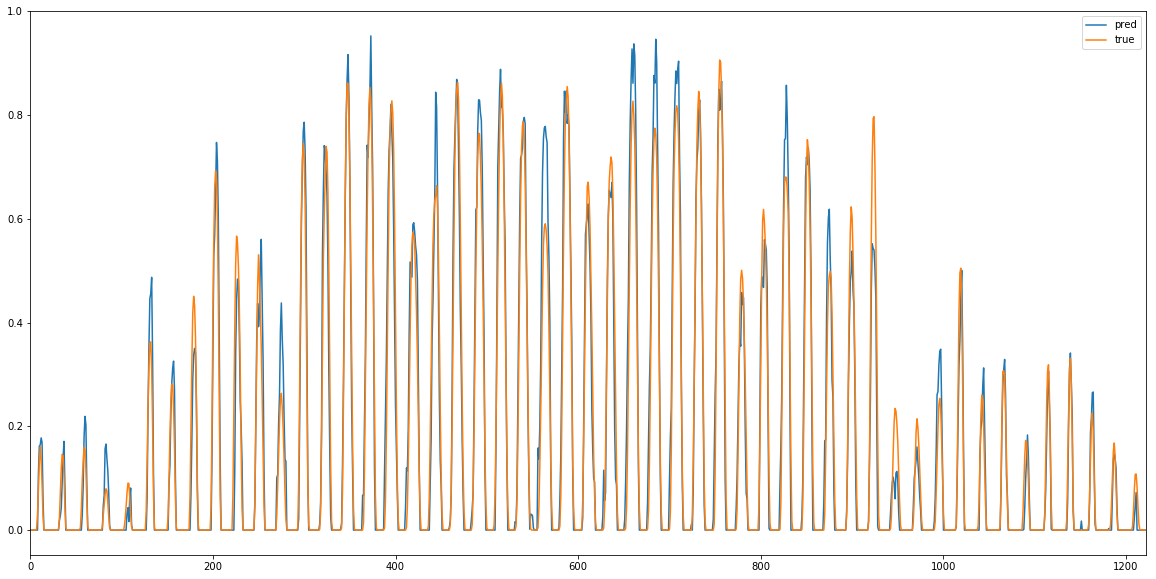

In [88]:
df.plot(figsize=(20,10))

## Forecasted Generation Data

In [11]:
output = fake_labels.solar_forecast.to_frame()

In [12]:
len(output)

8760

In [ ]:
index = indices[next(iter(indices))]

In [13]:
scaler = MinMaxScaler()
stacked_features, output, index = prep.align_transform_data(output.solar_forecast, tensors, VARS, scaler, index)

/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


features shape: (8759, 145, 110, 3)
labels shape: (8759,)


In [14]:
X_train, X_valid, X_test, y_train, y_valid, y_test = prep.daily_train_valid_test_split(stacked_features, output,
                                                                                  index,
                                                                                  ret_test_index=False)

In [15]:
samples, w, h, channels = (stacked_features.shape[i] for i in range(4))

In [23]:
input_layer = Input(shape=(w, h, channels))
x = Conv2D(64, activation='relu', kernel_size=(2, 2), strides=(2, 2), padding='same')(input_layer)
x = Conv2D(12, activation='relu', kernel_size=(5,5), strides=(5,5))(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dense(1, activation='relu')(x)
model = Model(inputs=input_layer, outputs=x)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 145, 110, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 73, 55, 64)        832       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 11, 12)        19212     
_________________________________________________________________
flatten_2 (Flatten)          (None, 1848)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                118336    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 138,445
Trainable params: 138,445
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

In [25]:
checkpoint = ModelCheckpoint('./models/renewable_pred_solar_forecast.hdf5', save_best_only=True)
hist = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), callbacks=[checkpoint])

Train on 6504 samples, validate on 1224 samples
Epoch 1/10
6504/6504 [==============================] - 5s - loss: 0.0108 - mean_absolute_error: 0.0594 - val_loss: 0.0081 - val_mean_absolute_error: 0.0515
Epoch 2/10
6504/6504 [==============================] - 4s - loss: 0.0081 - mean_absolute_error: 0.0505 - val_loss: 0.0068 - val_mean_absolute_error: 0.0458
Epoch 3/10
6504/6504 [==============================] - 4s - loss: 0.0063 - mean_absolute_error: 0.0441 - val_loss: 0.0073 - val_mean_absolute_error: 0.0465
Epoch 4/10
6504/6504 [==============================] - 4s - loss: 0.0057 - mean_absolute_error: 0.0416 - val_loss: 0.0067 - val_mean_absolute_error: 0.0458
Epoch 5/10
6504/6504 [==============================] - 4s - loss: 0.0042 - mean_absolute_error: 0.0361 - val_loss: 0.0055 - val_mean_absolute_error: 0.0399
Epoch 6/10
6504/6504 [==============================] - 4s - loss: 0.0038 - mean_absolute_error: 0.0346 - val_loss: 0.0048 - val_mean_absolute_error: 0.03770.036 - ETA

In [26]:
model = load_model('./models/renewable_pred_solar_forecast.hdf5')
pred = model.predict(X_test)

In [27]:
df = pd.DataFrame({'pred':pred.flatten(), 'true':y_test.flatten()})

In [28]:
print(mean_squared_error(y_test, pred))

0.00381653770406


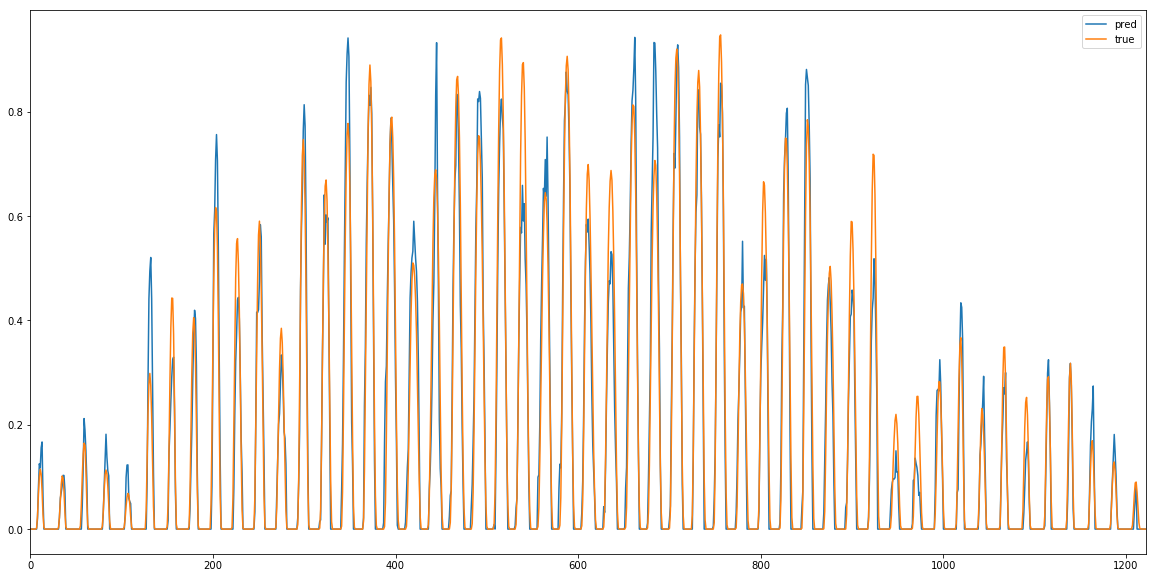

In [29]:
df.plot(figsize=(20,10))

# Wind Power

In [30]:
VARS = ['U_10M', 'V_10M']#, 'TOT_PRECIP']

In [31]:
indices, tensors = prep.prepare_training_data(range(1, 13, 1), VARS)

In [32]:
prep.check_indices(indices)

{'U_10M': Index([], dtype='object', name=0),
 'V_10M': Index([], dtype='object', name=0)}

In [33]:
for t in tensors.values():
    print(t.shape)

(8760, 145, 110)
(8760, 145, 110)


In [34]:
index = indices[next(iter(indices))]

## True Generation Data

In [91]:
labels['sum_wind'] = labels.wind_onshore + labels.wind_offshore

In [92]:
output = labels.sum_wind.to_frame()

In [ ]:
scaler = MinMaxScaler()
stacked_features, output, index = align_transform_data(output.sum_wind, tensors, VARS, scaler, index)

In [107]:
X_train, X_valid, X_test, y_train, y_valid, y_test = prep.daily_train_valid_test_split(stacked_features, output,
                                                                                  index,
                                                                                  ret_test_index=False)

In [108]:
samples, w, h, channels = (stacked_features.shape[i] for i in range(4))

In [109]:
input_layer = Input(shape=(w, h, channels))
x = Conv2D(64, activation='relu', kernel_size=(2, 2), strides=(2, 2), padding='same')(input_layer)
x = Conv2D(12, activation='relu', kernel_size=(5,5), strides=(5,5))(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dense(1, activation='relu')(x)
model = Model(inputs=input_layer, outputs=x)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 145, 110, 2)       0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 73, 55, 64)        576       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 14, 11, 12)        19212     
_________________________________________________________________
flatten_11 (Flatten)         (None, 1848)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 64)                118336    
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 65        
Total params: 138,189
Trainable params: 138,189
Non-trainable params: 0
_________________________________________________________________


In [110]:
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

In [111]:
checkpoint = ModelCheckpoint('./models/renewable_pred_wind.hdf5', save_best_only=True)
hist = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), callbacks=[checkpoint])

Train on 6503 samples, validate on 1224 samples
Epoch 1/10
6503/6503 [==============================] - 4s - loss: 0.0074 - mean_absolute_error: 0.0617 - val_loss: 0.0043 - val_mean_absolute_error: 0.0493
Epoch 2/10
6503/6503 [==============================] - 4s - loss: 0.0035 - mean_absolute_error: 0.0440 - val_loss: 0.0034 - val_mean_absolute_error: 0.0453
Epoch 3/10
6503/6503 [==============================] - 4s - loss: 0.0031 - mean_absolute_error: 0.0415 - val_loss: 0.0033 - val_mean_absolute_error: 0.0430
Epoch 4/10
6503/6503 [==============================] - 4s - loss: 0.0027 - mean_absolute_error: 0.0386 - val_loss: 0.0033 - val_mean_absolute_error: 0.0430
Epoch 5/10
6503/6503 [==============================] - 4s - loss: 0.0019 - mean_absolute_error: 0.0327 - val_loss: 0.0028 - val_mean_absolute_error: 0.0411
Epoch 6/10
6503/6503 [==============================] - 4s - loss: 0.0017 - mean_absolute_error: 0.0312 - val_loss: 0.0031 - val_mean_absolute_error: 0.0427
Epoch 7/10

In [112]:
model = load_model('./models/renewable_pred_wind.hdf5')
pred = model.predict(X_test)

In [113]:
df = pd.DataFrame({'pred':pred.flatten(), 'true':y_test.flatten()})

In [114]:
print(mean_squared_error(y_test, pred))

0.00232165779619


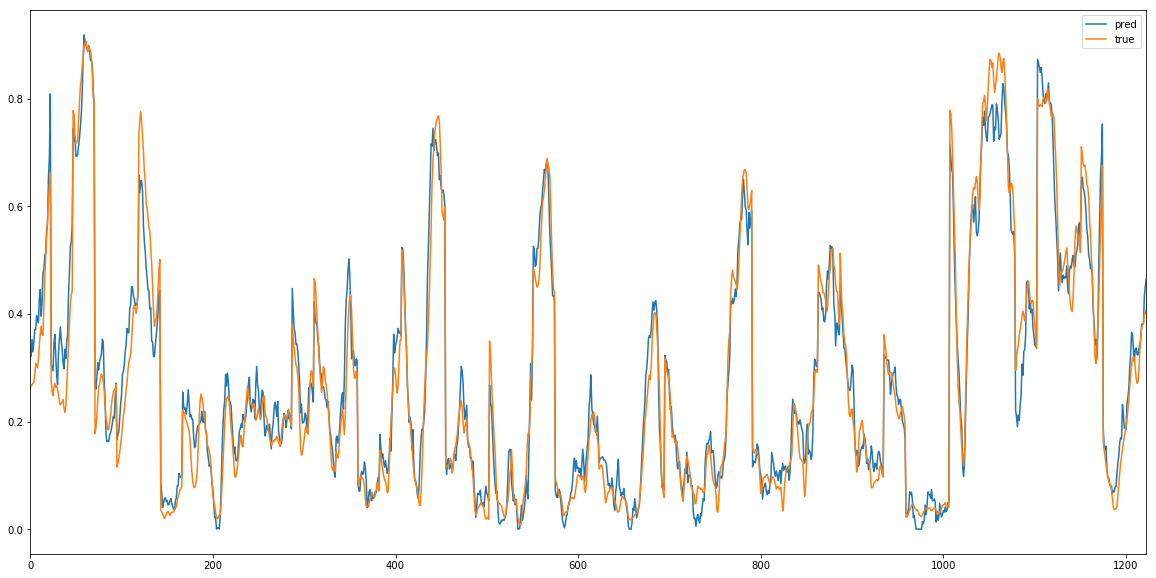

In [115]:
df.plot(figsize=(20,10))

## Forecasted Generation Data

In [36]:
fake_labels['sum_wind'] = fake_labels.onshore_forecast + fake_labels.offshore_forecast

In [37]:
index = indices[next(iter(indices))]

In [38]:
output = fake_labels.sum_wind.to_frame()

In [39]:
scaler = MinMaxScaler()
stacked_features, output, index = prep.align_transform_data(output.sum_wind, tensors, VARS, scaler, index)

/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


features shape: (8735, 145, 110, 2)
labels shape: (8735,)


In [40]:
X_train, X_valid, X_test, y_train, y_valid, y_test = prep.daily_train_valid_test_split(stacked_features, output,
                                                                                  index,
                                                                                  ret_test_index=False)

In [41]:
samples, w, h, channels = (stacked_features.shape[i] for i in range(4))

In [42]:
input_layer = Input(shape=(w, h, channels))
x = Conv2D(64, activation='relu', kernel_size=(2, 2), strides=(2, 2), padding='same')(input_layer)
x = Conv2D(12, activation='relu', kernel_size=(5,5), strides=(5,5))(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dense(1, activation='relu')(x)
model = Model(inputs=input_layer, outputs=x)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 145, 110, 2)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 73, 55, 64)        576       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 11, 12)        19212     
_________________________________________________________________
flatten_3 (Flatten)          (None, 1848)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                118336    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 138,189
Trainable params: 138,189
Non-trainable params: 0
_________________________________________________________________


In [43]:
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

In [44]:
checkpoint = ModelCheckpoint('./models/renewable_pred_wind_forecast.hdf5', save_best_only=True)
hist = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), callbacks=[checkpoint])

Train on 6480 samples, validate on 1224 samples
Epoch 1/10
6480/6480 [==============================] - 4s - loss: 0.0071 - mean_absolute_error: 0.0588 - val_loss: 0.0042 - val_mean_absolute_error: 0.0495
Epoch 2/10
6480/6480 [==============================] - 4s - loss: 0.0037 - mean_absolute_error: 0.0456 - val_loss: 0.0041 - val_mean_absolute_error: 0.0485
Epoch 3/10
6480/6480 [==============================] - 4s - loss: 0.0037 - mean_absolute_error: 0.0448 - val_loss: 0.0039 - val_mean_absolute_error: 0.0473
Epoch 4/10
6480/6480 [==============================] - 4s - loss: 0.0031 - mean_absolute_error: 0.0409 - val_loss: 0.0032 - val_mean_absolute_error: 0.0442
Epoch 5/10
6480/6480 [==============================] - 4s - loss: 0.0026 - mean_absolute_error: 0.0373 - val_loss: 0.0037 - val_mean_absolute_error: 0.0449
Epoch 6/10
6480/6480 [==============================] - 4s - loss: 0.0024 - mean_absolute_error: 0.0362 - val_loss: 0.0033 - val_mean_absolute_error: 0.0433
Epoch 7/10

In [45]:
model = load_model('./models/renewable_pred_wind_forecast.hdf5')
pred = model.predict(X_test)

In [46]:
df = pd.DataFrame({'pred':pred.flatten(), 'true':y_test.flatten()})

In [47]:
print(mean_squared_error(y_test, pred))

0.0029545189384


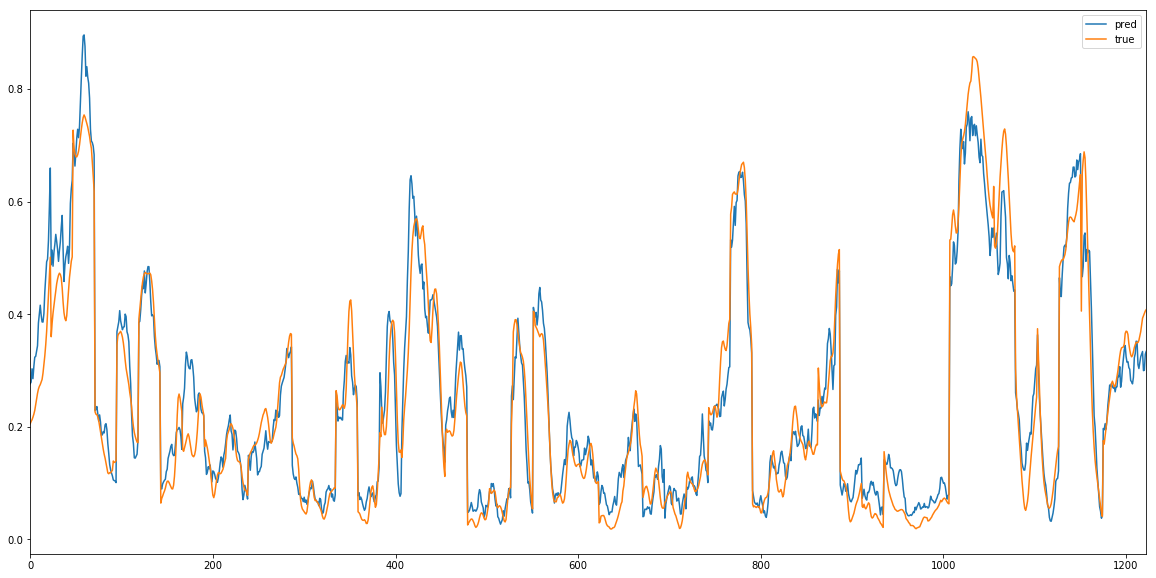

In [48]:
df.plot(figsize=(20,10))